[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Mean Squared Error: 280.12016090478943
MAPE: 2.217067545766562%
R² Score: 0.9989329717043189


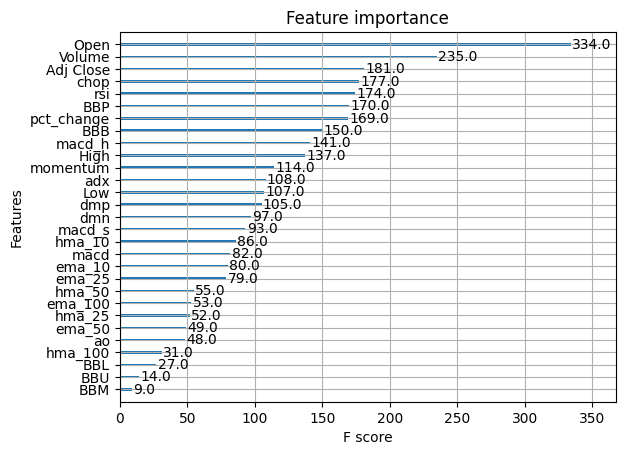


Predicting for PLTR...

Predicting for CRWD...

Predicting for NOW...

Predicting for FICO...

Predicting for PANW...

Predicting for ANET...

Predicting for CDNS...

Predicting for QCOM...

Predicting for DELL...

Predicting for MU...


In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Preprocessing and feature extraction
def preprocess(stock_symbols, start, end):
    strat = ta.Strategy(
        name='Best Strategy Ever',
        ta=[
            {'kind':'ema', 'length':10, 'col_names':'ema_10'},
            {'kind':'ema', 'length':25, 'col_names':'ema_25'},
            {'kind':'ema', 'length':50, 'col_names':'ema_50'},
            {'kind':'ema', 'length':100, 'col_names':'ema_100'},
            {'kind':'hma', 'length':10, 'col_names':'hma_10'},
            {'kind':'hma', 'length':25, 'col_names':'hma_25'},
            {'kind':'hma', 'length':50, 'col_names':'hma_50'},
            {'kind':'hma', 'length':100, 'col_names':'hma_100'},
            {'kind':'macd', 'col_names':('macd', 'macd_h', 'macd_s')},
            {'kind':'rsi', 'col_names':'rsi'},
            {'kind':'mom', 'col_names':'momentum'},
            {'kind':'bbands', 'std':1, 'col_names':('BBL', 'BBM', 'BBU', 'BBB', 'BBP')},
            {'kind':'ao', 'col_names':'ao'},
            {'kind':'adx', 'col_names':('adx', 'dmp', 'dmn')},
            {'kind':'chop', 'col_names':'chop'},
        ]
    )
    stock_data = []
    for symbol in stock_symbols:
        data = yf.download(symbol, start=start, end=end).reset_index()
        data.ta.strategy(strat)
        data['pct_change'] = data['Close'].pct_change()
        data['target'] = data['Close'].shift(-1)  # Predict next day's price
        data['Symbol'] = symbol  # Add a column for stock symbol
        stock_data.append(data.dropna())
    return pd.concat(stock_data, ignore_index=True)

# Predict for the next N days
def predict_next_days_for_stock(model, stock_data, stock_features, days=10):
    latest_data = stock_data.tail(days).copy()
    latest_features = stock_features.tail(days)
    predictions = model.predict(latest_features)
    return predictions

# Main workflow
if __name__ == "__main__":
    # Define inputs
    start_date = "2024-01-01"
    end_date = "2025-01-01"
    #XLK-69
    technology_stocks_test = [
        "PLTR",  # Palantir Technologies Inc
        "CRWD",  # CrowdStrike Holdings Inc
        "NOW",   # ServiceNow Inc
        "FICO",  # Fair Isaac Corp
        "PANW",  # Palo Alto Networks Inc
        "ANET",  # Arista Networks Inc
        "CDNS",  # Cadence Design Systems Inc
        "QCOM",  # Qualcomm Inc
        "DELL",  # Dell Technologies Inc
        "MU"     # Micron Technology Inc
    ]
    # Preprocess data
    data = preprocess(technology_stocks_test, start_date, end_date)

    # Prepare features and target
    features = data.drop(columns=['Date', 'Close', 'target', 'Symbol'])
    target = data['target']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Train XGBoost model
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1)
    xg_reg.fit(X_train, y_train)

    # Make predictions
    predictions = xg_reg.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    r2 = r2_score(y_test, predictions)

    print(f"Mean Squared Error: {mse}")
    print(f"MAPE: {mape}%")
    print(f"R² Score: {r2}")

    # Plot feature importance
    xgb.plot_importance(xg_reg)
    plt.show()

    # Predict next 10 days for all stocks
    all_predictions = {}
    for stock in technology_stocks_test:
        print(f"\nPredicting for {stock}...")
        
        # Filter data for the specific stock
        stock_data = data[data['Symbol'] == stock]
        stock_features = stock_data.drop(columns=['Date', 'Close', 'target', 'Symbol'])

        # Predict for the next 10 days
        predictions = predict_next_days_for_stock(xg_reg, stock_data, stock_features, days=10)
        all_predictions[stock] = predictions

In [9]:
# Predict next 10 days for all stocks and compare with actual prices
all_predictions = {}
all_actuals = {}
all_differences = {}
average_percentage_differences = {}

for stock in technology_stocks_test:
    print(f"\nPredicting for {stock}...\n")
    
    # Filter data for the specific stock
    stock_data = data[data['Symbol'] == stock]
    stock_features = stock_data.drop(columns=['Date', 'Close', 'target', 'Symbol'])  # Exclude 'Symbol' from features

    # Predict for the next 10 days
    predictions = predict_next_days_for_stock(xg_reg, stock_data, stock_features, days=10)
    all_predictions[stock] = predictions
    
    # Fetch actual future prices (next 10 days) for comparison
    future_data = yf.download(stock, start=end_date, end="2025-02-10")  # Assuming the next 10 days are after the end_date
    
    # Ensure that we have enough data
    if len(future_data) >= 10:
        actual_prices = future_data['Close'].head(10).values
        all_actuals[stock] = actual_prices
    else:
        print(f"Warning: Not enough data for {stock}. Skipping comparison.")
        all_actuals[stock] = np.array([])  # Set an empty array if there is not enough data

# Calculate the average percentage difference for each stock
for stock in technology_stocks_test:
    print(f"\n{stock} Predictions vs Actuals for the Next 10 Days:")
    predictions = all_predictions[stock]
    actuals = all_actuals[stock]
    
    # Check if actuals are empty
    if actuals.size > 0:
        differences = predictions - actuals
        percentage_differences = (differences / actuals) * 100

        for day in range(10):
            print(f"Day {day + 1}: Predicted Price = {predictions[day]:.2f}, Actual Price = {actuals[day]:.2f}, "
                  f"Difference = {differences[day]:.2f}, Percentage Difference = {percentage_differences[day]:.2f}%")
        
        # Calculate the average percentage difference
        avg_percentage_diff = np.mean(np.abs(percentage_differences))
        average_percentage_differences[stock] = avg_percentage_diff
        print(f"Average Percentage Difference for {stock}: {avg_percentage_diff:.2f}%")
    else:
        print("No actual data available for comparison.")

# Print the average percentage difference for all stocks
print("\nAverage Percentage Difference for Each Stock:")
for stock, avg_diff in average_percentage_differences.items():
    print(f"{stock}: {avg_diff:.2f}%")


Predicting for PLTR...



[*********************100%***********************]  1 of 1 completed


Predicting for CRWD...




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Predicting for NOW...


Predicting for FICO...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Predicting for PANW...


Predicting for ANET...


Predicting for CDNS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Predicting for QCOM...


Predicting for DELL...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Predicting for MU...


PLTR Predictions vs Actuals for the Next 10 Days:
Day 1: Predicted Price = 74.89, Actual Price = 75.19, Difference = -0.30, Percentage Difference = -0.40%
Day 2: Predicted Price = 73.45, Actual Price = 79.89, Difference = -6.44, Percentage Difference = -8.06%
Day 3: Predicted Price = 75.33, Actual Price = 75.92, Difference = -0.59, Percentage Difference = -0.78%
Day 4: Predicted Price = 77.56, Actual Price = 69.99, Difference = 7.57, Percentage Difference = 10.81%
Day 5: Predicted Price = 80.52, Actual Price = 68.23, Difference = 12.29, Percentage Difference = 18.01%
Day 6: Predicted Price = 82.50, Actual Price = 67.26, Difference = 15.24, Percentage Difference = 22.65%
Day 7: Predicted Price = 82.88, Actual Price = 64.98, Difference = 17.90, Percentage Difference = 27.55%
Day 8: Predicted Price = 82.48, Actual Price = 65.91, Difference = 16.57, Percentage Difference = 25.14%
Day 9: Predicted Price = 81.86, Actual Price = 68.14, Difference = 13.72, Percentage Di

In [10]:
# Print the average percentage difference for all stocks
print("\nAverage Percentage Difference for Each Stock:")
for stock, avg_diff in average_percentage_differences.items():
    print(f"{stock}: {avg_diff:.2f}%")


Average Percentage Difference for Each Stock:
PLTR: 14.31%
CRWD: 4.25%
NOW: 3.75%
FICO: 5.62%
PANW: 7.54%
ANET: 3.43%
CDNS: 2.21%
QCOM: 2.90%
DELL: 5.82%
MU: 12.28%
